This is a notebook that use the FLOCELLID_taxa.tab file in the WGS folder to generate ncbi hit plot for the four flowcells.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import product

In [2]:
BASEDIR = '/home/yiheng/analysis/WGS'

In [3]:
# get the summary dataframe for total reads
FC1_totaltaxa = os.path.join(BASEDIR, 'run1_totaltaxa.tab')
FC2_totaltaxa = os.path.join(BASEDIR, 'run2_totaltaxa.tab')
FC3_totaltaxa = os.path.join(BASEDIR, 'FAH05432_totaltaxa.tab')
FC4_totaltaxa = os.path.join(BASEDIR, 'FAH05731_totaltaxa.tab')

FC1_totaltaxa_df = pd.read_csv(FC1_totaltaxa, sep = '\t')
FC2_totaltaxa_df = pd.read_csv(FC2_totaltaxa, sep = '\t')
FC3_totaltaxa_df = pd.read_csv(FC3_totaltaxa, sep = '\t')
FC4_totaltaxa_df = pd.read_csv(FC4_totaltaxa, sep = '\t')

# now get the summary dataframe for nt hit reads
FC1_nttaxa = os.path.join(BASEDIR, 'run1_nttaxa.tab')
FC2_nttaxa = os.path.join(BASEDIR, 'run2_nttaxa.tab')
FC3_nttaxa = os.path.join(BASEDIR, 'FAH05432_nttaxa.tab')
FC4_nttaxa = os.path.join(BASEDIR, 'FAH05731_nttaxa.tab')

FC1_nttaxa_df = pd.read_csv(FC1_nttaxa, sep = '\t')
FC2_nttaxa_df = pd.read_csv(FC2_nttaxa, sep = '\t')
FC3_nttaxa_df = pd.read_csv(FC3_nttaxa, sep = '\t')
FC4_nttaxa_df = pd.read_csv(FC4_nttaxa, sep = '\t')

In [4]:
joint_totaltaxa_df = pd.concat([FC1_totaltaxa_df,  
                                FC2_totaltaxa_df,
                                FC3_totaltaxa_df,
                                FC4_totaltaxa_df], ignore_index=True)
joint_nttaxa_df = pd.concat([FC1_nttaxa_df,  
                             FC2_nttaxa_df,
                             FC3_nttaxa_df,
                             FC4_nttaxa_df], ignore_index=True)

In [5]:
len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode05')])

292783

In [6]:
#Defines a function to make manual adjustments to the NCBI taxonomic sorting
def manually_adjust_ncbi_taxonomy(rank_select, entry_select, ranks_to_edit, new_entry):
    """Select dataframe entries to edit by a specific rank (rank_select) 
    and entry related to that rank (entry_select), 
    provide a list of ranks to edit for those selected entries (ranks_to_edit),
    replace these ranks with a new entry (new_entry)"""
    if entry_select in list(joint_nttaxa_df[rank_select].unique()):
        selection = (joint_nttaxa_df[rank_select] == entry_select)
        selected_tax_ranks = ranks_to_edit
        for ranks in selected_tax_ranks:
            joint_nttaxa_df[ranks][selection] = new_entry

In [7]:
manually_adjust_ncbi_taxonomy('species', 
                            'Cloning vector lambda TXF97', 
                            ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus'], 
                            'Cloning vector lambda TXF97')

manually_adjust_ncbi_taxonomy('superkingdom', 
                            'Viruses', 
                            ['phylum', 'class'], 
                            'dsDNA viruses, no RNA stage')

/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [8]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='sequence_length_template', 
                                            index=rank, 
                                            columns='barcode_arrangement', 
                                            aggfunc='sum', 
                                            fill_value=0)
    pivot_table.columns.name = None
    return pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [9]:
generate_ncbi_taxonomy_pivot(joint_nttaxa_df, 'genus','barcode01',10)

,barcode01,barcode02,barcode03,barcode04,barcode05
genus,,,,,
Pseudomonas,6891521,5098735,550911,7423767,69778
Erwinia,679463,19406,0,801,3962
Alternaria,398844,1488164,393167,1202371,32527
Puccinia,228659,0,0,24179,0
Pantoea,183938,38855,0,92930,3039
Serratia,99788,5289,0,3063,0
Enterobacter,50363,8733,0,606,0
Massilia,48395,37504,0,135274,0
Escherichia,47627,147907,27500,93883,71779


In [10]:
barcode01_df = joint_totaltaxa_df[(joint_totaltaxa_df.barcode_arrangement.str.contains('barcode01')) & joint_totaltaxa_df.sseqid_rg.str.contains('Wheat')]
barcode02_df = joint_totaltaxa_df[(joint_totaltaxa_df.barcode_arrangement.str.contains('barcode02')) & joint_totaltaxa_df.sseqid_rg.str.contains('Wheat')]
barcode03_df = joint_totaltaxa_df[(joint_totaltaxa_df.barcode_arrangement.str.contains('barcode03')) & joint_totaltaxa_df.sseqid_rg.str.contains('Wheat')]
barcode04_df = joint_totaltaxa_df[(joint_totaltaxa_df.barcode_arrangement.str.contains('barcode04')) & joint_totaltaxa_df.sseqid_rg.str.contains('Wheat')]
barcode05_df = joint_totaltaxa_df[(joint_totaltaxa_df.barcode_arrangement.str.contains('barcode05')) & joint_totaltaxa_df.sseqid_rg.str.contains('Wheat')]

In [11]:
barcode01_total_df = joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode01')]
barcode02_total_df = joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode02')]
barcode03_total_df = joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode03')]
barcode04_total_df = joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode04')]
barcode05_total_df = joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode05')]

In [12]:
total_wheat_length_of_each_barcode_df = pd.DataFrame({'barcode01':sum(barcode01_total_df.sequence_length_template),
                                                      'barcode02':sum(barcode02_total_df.sequence_length_template),
                                                      'barcode03':sum(barcode03_total_df.sequence_length_template),
                                                      'barcode04':sum(barcode04_total_df.sequence_length_template),
                                                      'barcode05':sum(barcode05_total_df.sequence_length_template)},index = [0])

In [13]:
pivot_df = generate_ncbi_taxonomy_pivot(joint_nttaxa_df, 'genus','barcode04',10)

In [14]:
# % pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_pc(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank %, sorted ascending by bcs"""
    pivot_table_pc = generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num)
    
    for ind, brcs in enumerate(pivot_table_pc.columns):
        pivot_table_pc[str(brcs) + '%'] = pivot_table_pc[brcs].apply(lambda x: (x / total_wheat_length_of_each_barcode_df.iloc[0,ind])*100)
    for brcs in pivot_table_pc.columns:
        if '%' not in brcs:
            pivot_table_pc.drop(brcs, axis=1, inplace=True)
    

    pivot_table_pc2 = pivot_table_pc.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return pivot_table_pc2.applymap(lambda x: '%.3f' % x).head(n=num)

In [15]:
generate_ncbi_taxonomy_pivot_pc(joint_nttaxa_df, 'species', 'barcode01', 20)

,barcode01%,barcode02%,barcode03%,barcode04%,barcode05%
species,,,,,
Pseudomonas syringae,0.725,0.424,0.021,0.516,0.003
Pseudomonas poae,0.070,0.106,0.010,0.167,0.006
Alternaria solani,0.037,0.133,0.038,0.093,0.004
Erwinia tasmaniensis,0.025,0.000,0.000,0.000,0.000
Erwinia pyrifoliae,0.019,0.001,0.000,0.000,0.000
Puccinia graminis,0.017,0.000,0.000,0.002,0.000
Erwinia billingiae,0.017,0.000,0.000,0.000,0.000
Alternaria alternata,0.014,0.066,0.018,0.046,0.001
Pseudomonas savastanoi,0.013,0.003,0.000,0.003,0.000


In [16]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(joint_nttaxa_df['barcode_arrangement'].unique())
no_of_subplots = len(ncbiblast_barcodes)

In [17]:
#Always 2 columns, bc-count/2 rows 
#no_of_subplots_pair = [int(no_of_subplots/2), 2]
no_of_subplots_pair = [0, int(no_of_subplots)]
#Produce pairs of indices correlating to the coordinates of the subplots
#subplot_coordinates = list(range(no_of_subplots_pair[1]))
#subplot_coordinates_list = [list(l) for l in subplot_coordinates]
#subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
#subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

#fig, ax = plt.subplots(0, no_of_subplots, figsize=(20, 6))

In [18]:
no_of_subplots_pair

[0, 5]

In [19]:
name_list = ['barcode01 (Stripe rust)', 'barcode02 (Septoria tritici blotch)', 'barcode03 (Yellow spot)', 'barcode04 (Stripe rust + Septoria tritici blotch)','barcode05 (Healthy wheat)' ]

In [20]:
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank, name):
    labels = ''
    labels = tuple(generate_ncbi_taxonomy_pivot_pc(joint_nttaxa_df, rank, bcs, 10)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_ncbi_taxonomy_pivot_pc(joint_nttaxa_df, rank, bcs, 10)[bcs + '%']])
    
    ax[ax_ind1].barh(y_pos, sizes, align='center', alpha=0.4, color=get_color(2*ax_ind2 + ax_ind1))
    ax[ax_ind1].set_yticks(y_pos)
    ax[ax_ind1].set_yticklabels(labels)
    ax[ax_ind1].tick_params(top="off", right="off", left="off")
    ax[ax_ind1].set_xlabel('Percentage of Microbe Total Length (%)')
    ax[ax_ind1].set_xticks(range(0, 2),0.2)
    ax[ax_ind1].set_title(name, fontsize=14)
    ax[ax_ind1].invert_yaxis()
    ax[ax_ind1].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
#    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
#             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=14, xytext=(-20, -30), textcoords='offset points', 
#             ha='right', va='bottom')

    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, name in zip(range(0, 5), [0, 0, 0, 0, 0], ncbiblast_barcodes, name_list):
        
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank, name)    

    #if len(list(joint_nttaxa_df['barcode_arrangement'].unique())) != 0:
    #    plt.delaxes(ax[0])
    
#    plt.suptitle('Reads Hitting NCBI Database - Percentage By ' + str(search_rank).title() + ' By Sample', 
#             fontsize='xx-large',
#             y=1.02,
#             fontweight="bold")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
    plt.tight_layout()
    
    plt.savefig(BASEDIR + '/figures/' + 'figure3_%s.png' % search_rank, bbox_inches='tight', dpi = 600)
    plt.show()
    print(ax_ind1, ax_ind2)        


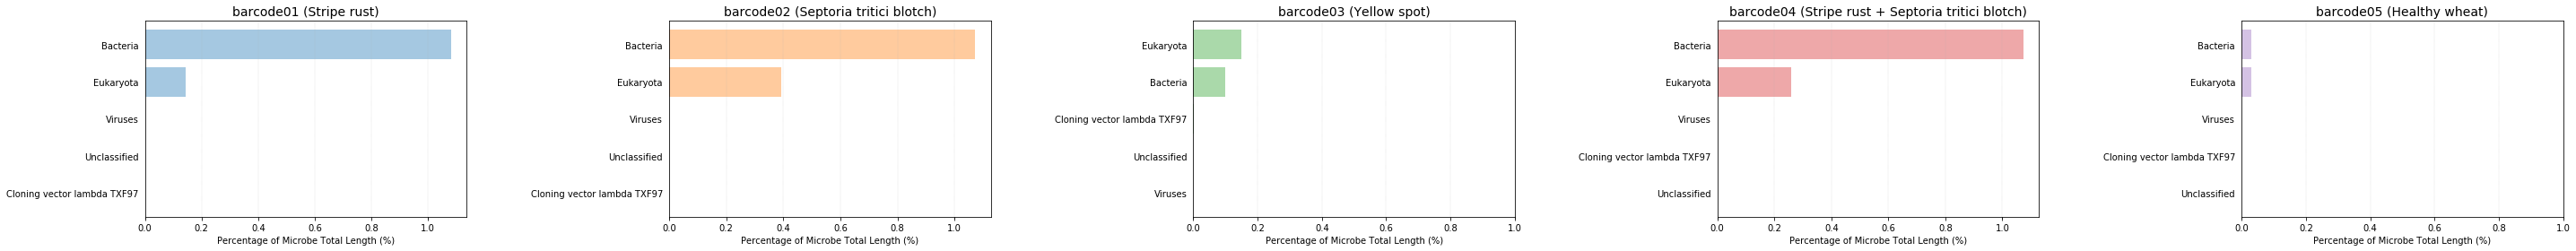

4 0


In [21]:
fig, ax = plt.subplots(1, no_of_subplots, figsize=(40, 4))
generateTaxSubplots('superkingdom')
